## Phase 2

In [1]:
CRACKS_PATH = "/kaggle/input/prompt-based-segmentation/cracks-1"
DRYWALL_PATH = "/kaggle/input/prompt-based-segmentation/Drywall-Join-Detect-1"

# Print the paths
print(f"\nCracks dataset location: {CRACKS_PATH}")
print(f"Drywall dataset location: {DRYWALL_PATH}")


Cracks dataset location: /kaggle/input/prompt-based-segmentation/cracks-1
Drywall dataset location: /kaggle/input/prompt-based-segmentation/Drywall-Join-Detect-1


Visualizing CRACKS dataset samples...


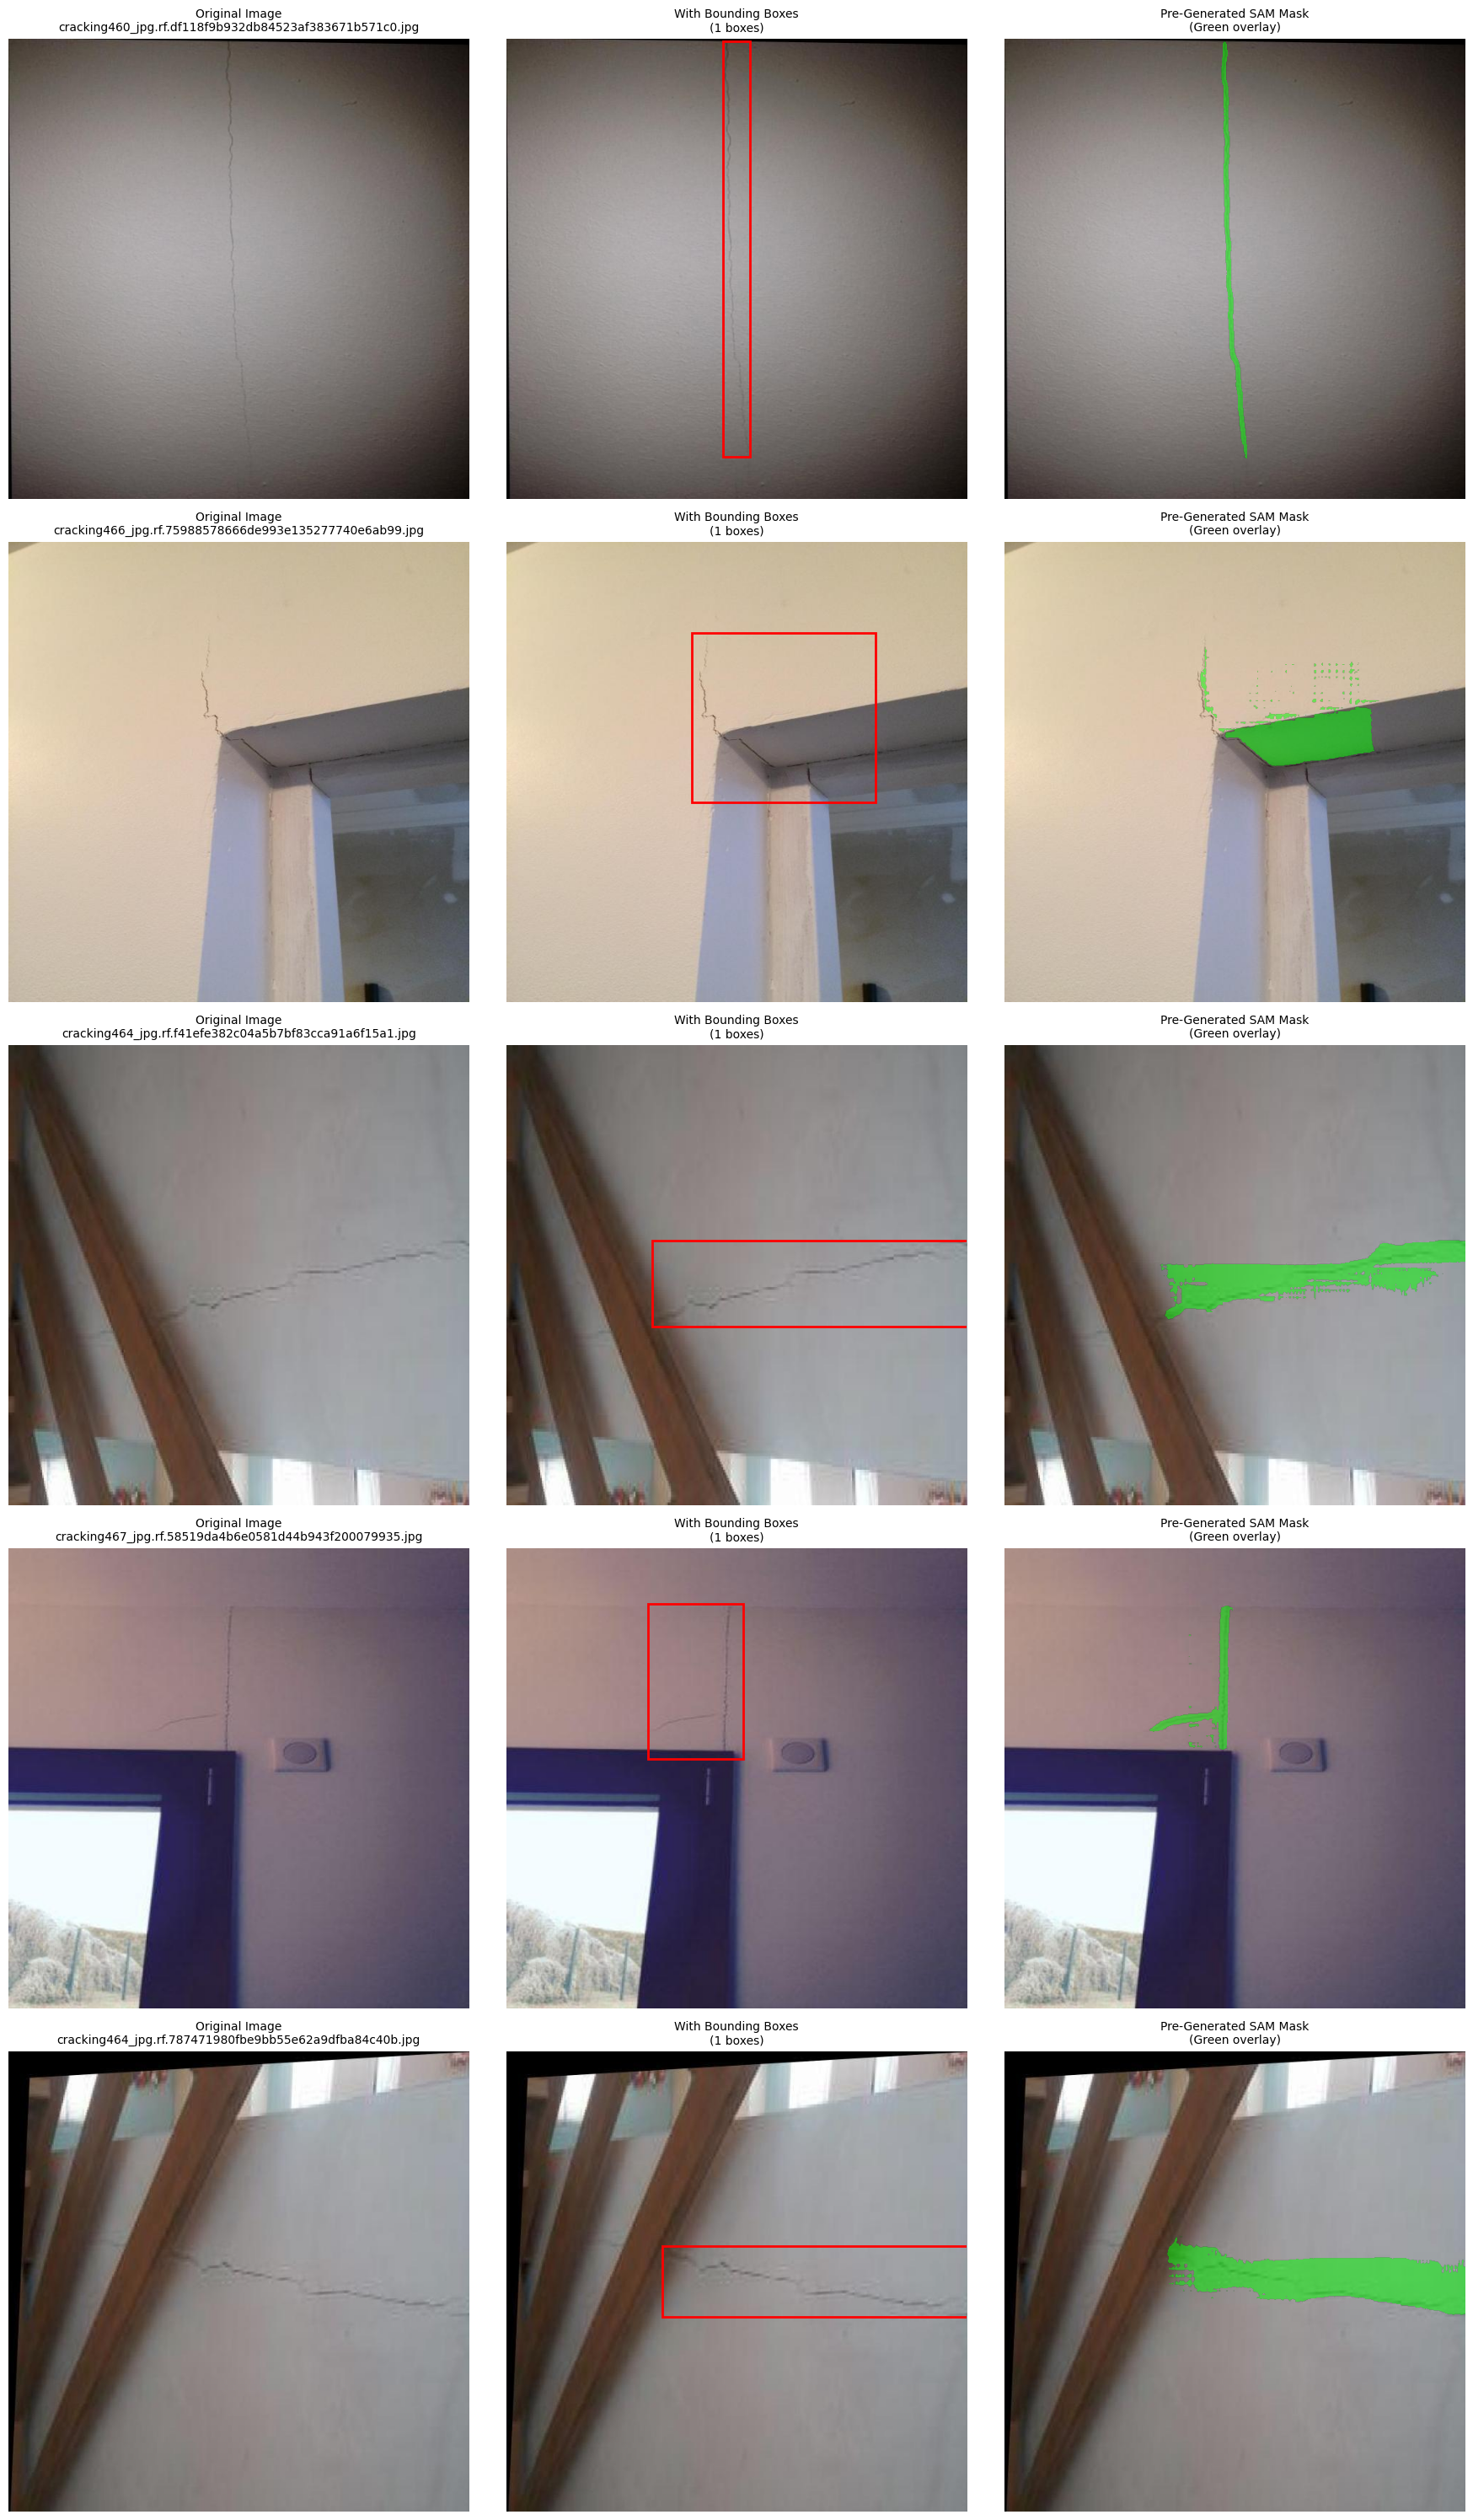


✓ Visualization complete for 5 samples from cracks-1/train


In [2]:
import os
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_generated_masks(dataset_path, dataset_name, masks_dir, split="train", num_samples=3):
    """
    Visualize already-generated masks with original images and bounding boxes.
    """
    # Load annotations from specified split
    split_dir = os.path.join(dataset_path, split)
    ann_path = os.path.join(split_dir, '_annotations.coco.json')
    
    with open(ann_path, 'r') as f:
        coco = json.load(f)
    
    # Create image lookup
    images_dict = {img["id"]: img["file_name"] for img in coco["images"]}
    
    # Group annotations by image
    bbox_map = {}
    for ann in coco["annotations"]:
        img_id = ann["image_id"]
        bbox_coco = ann["bbox"]  # [x_min, y_min, width, height]
        x_min, y_min, w, h = bbox_coco
        bbox_xyxy = [x_min, y_min, x_min + w, y_min + h]
        bbox_map.setdefault(img_id, []).append(bbox_xyxy)
    
    # Select samples with annotations
    sample_ids = [img_id for img_id in list(bbox_map.keys())[:num_samples]]
    
    # Visualize each sample
    fig, axes = plt.subplots(num_samples, 3, figsize=(18, 6*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for idx, img_id in enumerate(sample_ids):
        img_name = images_dict[img_id]
        img_path = os.path.join(split_dir, img_name)
        bboxes = bbox_map[img_id]
        
        # Read original image
        image_bgr = cv2.imread(img_path)
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        
        # Load the pre-generated mask
        base_name = os.path.splitext(img_name)[0]
        mask_name = f"{dataset_name}_{split}_{base_name}.png"
        mask_path = os.path.join(masks_dir, mask_name)
        
        if os.path.exists(mask_path):
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask_bool = mask > 0
        else:
            print(f"Warning: Mask not found at {mask_path}")
            mask_bool = np.zeros(image_rgb.shape[:2], dtype=bool)
        
        # Plot 1: Original Image
        axes[idx, 0].imshow(image_rgb)
        axes[idx, 0].set_title(f'Original Image\n{img_name}', fontsize=10)
        axes[idx, 0].axis('off')
        
        # Plot 2: Image with Bounding Boxes
        axes[idx, 1].imshow(image_rgb)
        for bbox in bboxes:
            x_min, y_min, x_max, y_max = bbox
            rect = patches.Rectangle(
                (x_min, y_min), x_max - x_min, y_max - y_min,
                linewidth=2, edgecolor='red', facecolor='none'
            )
            axes[idx, 1].add_patch(rect)
        axes[idx, 1].set_title(f'With Bounding Boxes\n({len(bboxes)} boxes)', fontsize=10)
        axes[idx, 1].axis('off')
        
        # Plot 3: Image with Generated Mask Overlay
        axes[idx, 2].imshow(image_rgb)
        # Create colored mask overlay
        mask_overlay = np.zeros((*mask_bool.shape, 4))
        mask_overlay[mask_bool] = [0, 1, 0, 0.5]  # Green with 50% transparency
        axes[idx, 2].imshow(mask_overlay)
        axes[idx, 2].set_title('Pre-Generated SAM Mask\n(Green overlay)', fontsize=10)
        axes[idx, 2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Visualization complete for {num_samples} samples from {dataset_name}/{split}")

# Path to processed masks
MASKS_DIR = "/kaggle/input/prompt-based-segmentation/processed_masks"

# Visualize samples from cracks dataset
print("="*60)
print("Visualizing CRACKS dataset samples...")
print("="*60)
visualize_generated_masks(CRACKS_PATH, "cracks-1", MASKS_DIR, num_samples=5)


Visualizing DRYWALL dataset samples...


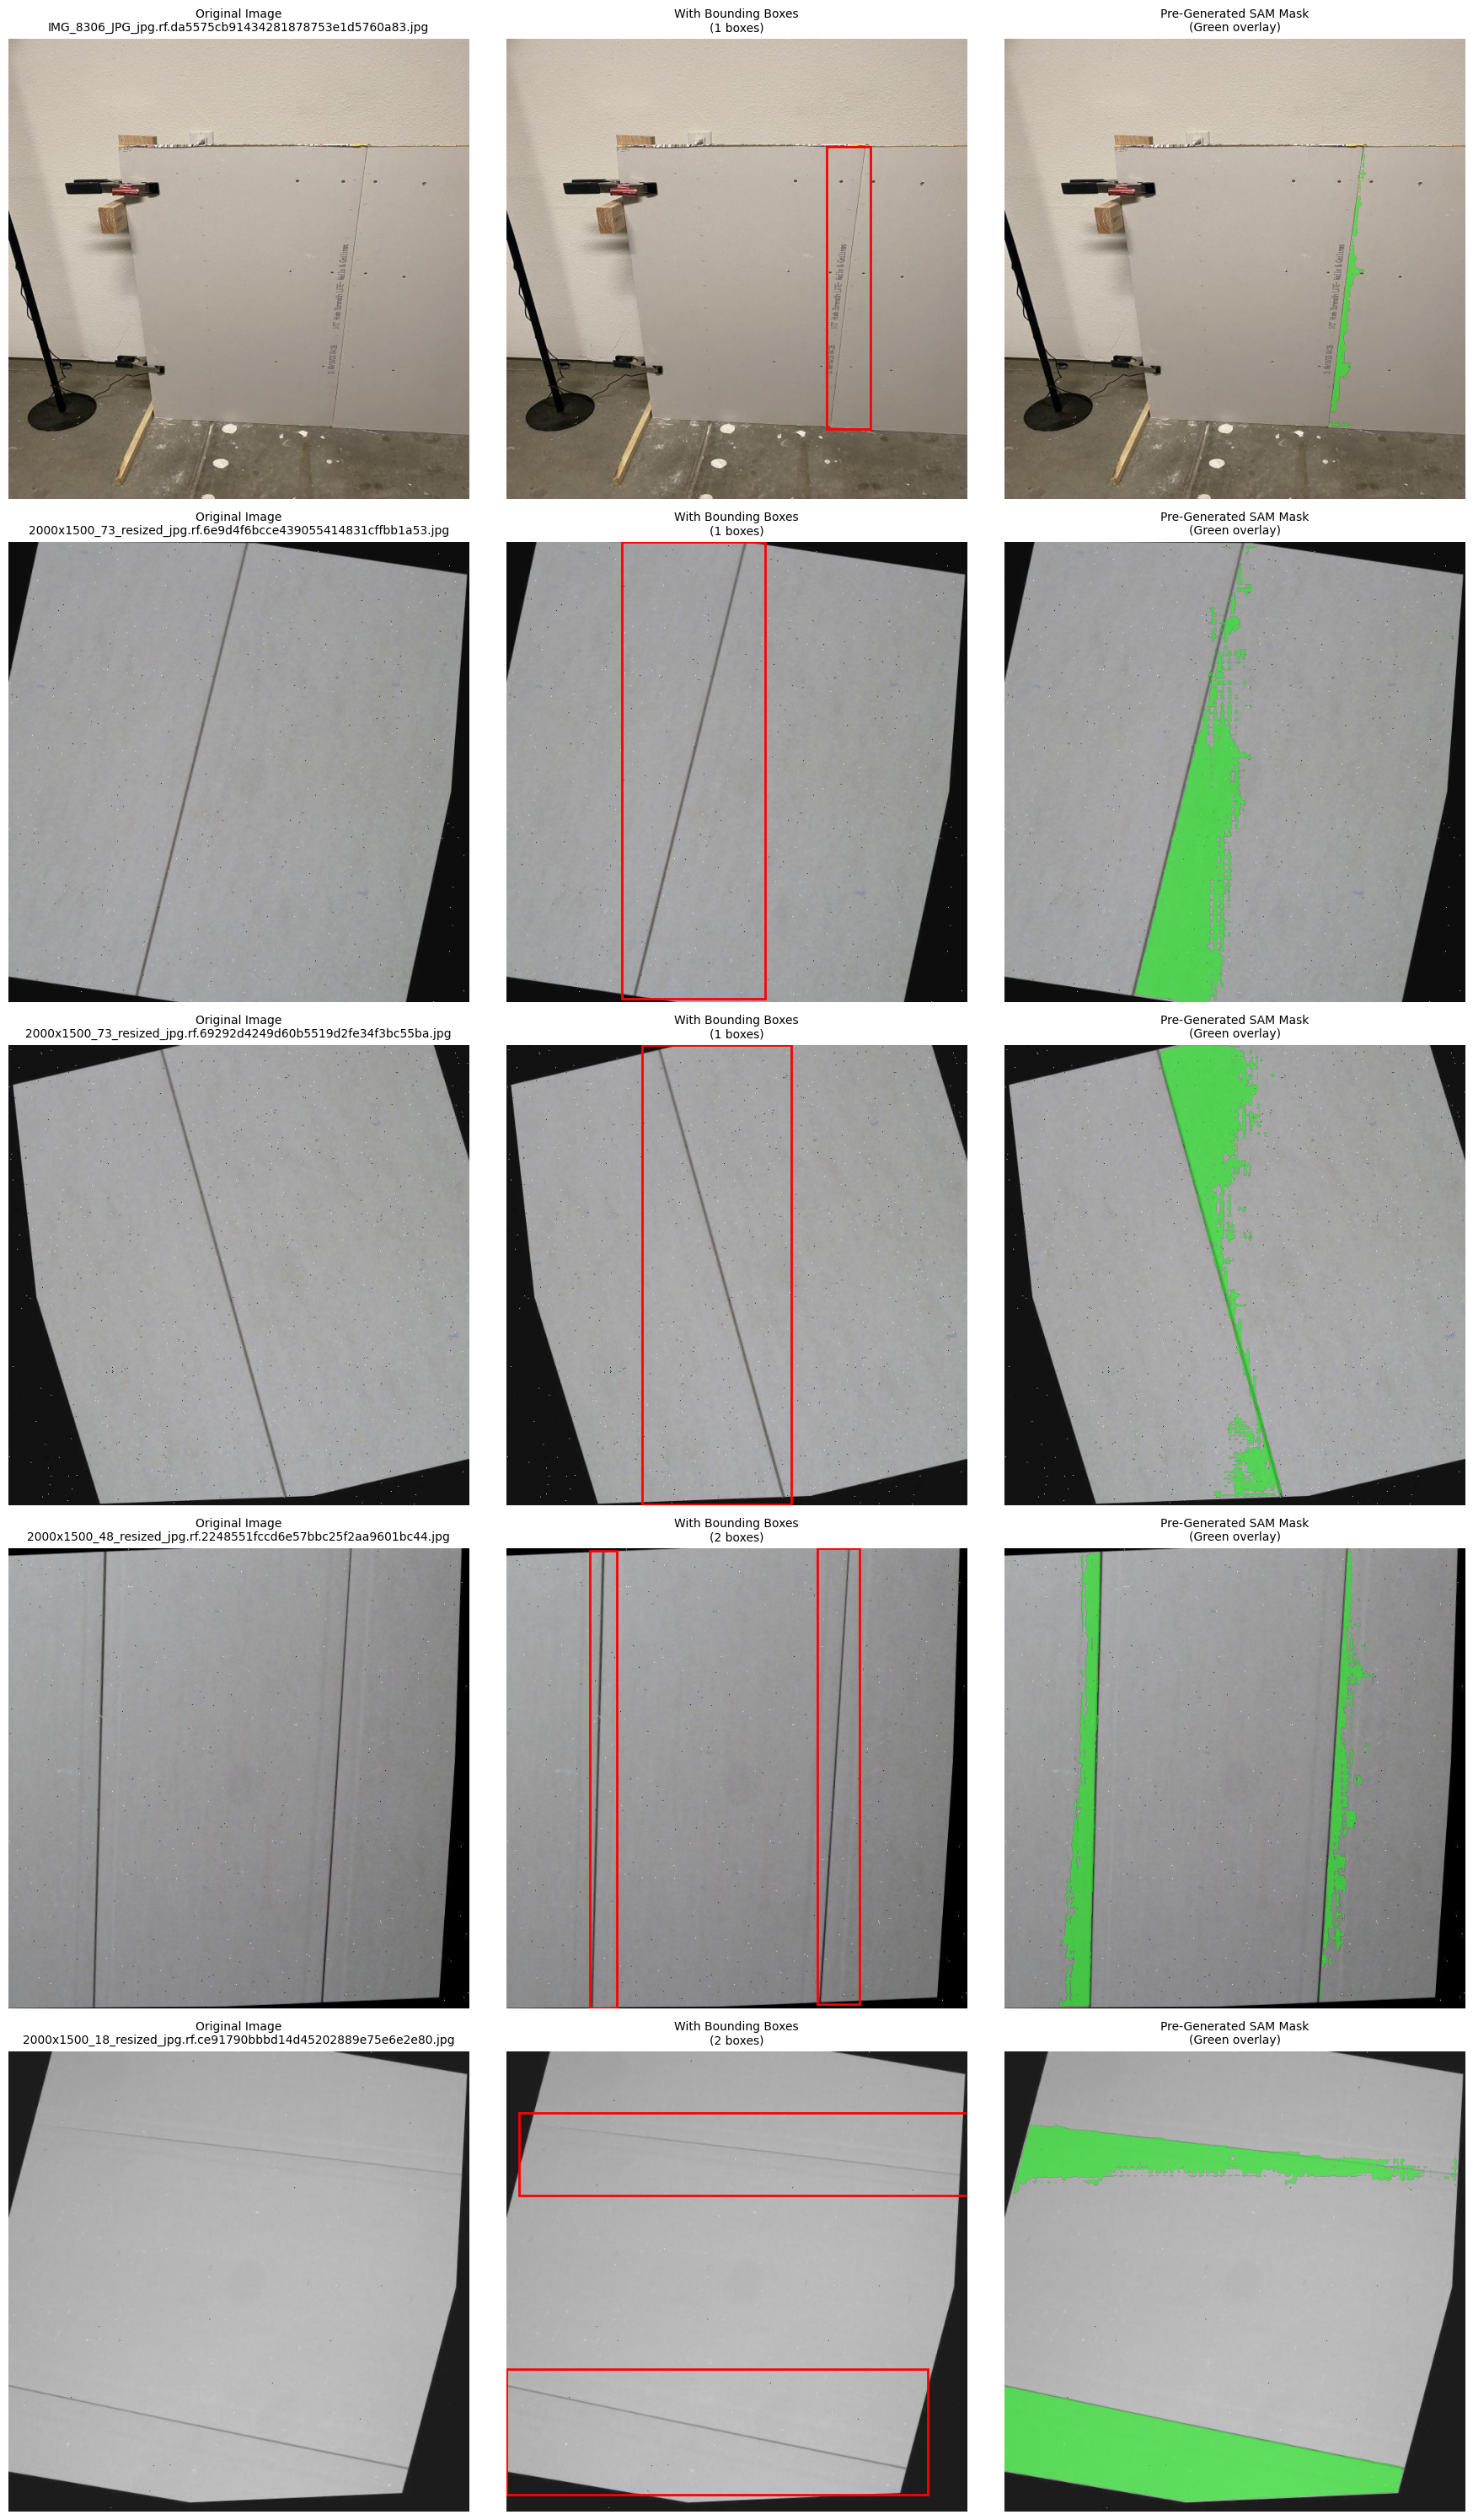


✓ Visualization complete for 5 samples from Drywall-Join-Detect-1/train


In [3]:
# Visualize samples from drywall dataset
print("\n" + "="*60)
print("Visualizing DRYWALL dataset samples...")
print("="*60)
visualize_generated_masks(DRYWALL_PATH, "Drywall-Join-Detect-1", MASKS_DIR, num_samples=5)

## Data Augmentation

In [4]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import albumentations as A

# Install albumentations if needed
try:
    import albumentations
except ImportError:
    !pip install albumentations

def count_images_and_masks(dataset_path, masks_dir, dataset_name):
    """Count total images and masks across all splits"""
    total_images = 0
    total_masks = 0
    
    for split in ['train', 'valid', 'test']:
        split_dir = os.path.join(dataset_path, split)
        if os.path.exists(split_dir):
            images = [f for f in os.listdir(split_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
            total_images += len(images)
    
    # Count masks
    mask_files = [f for f in os.listdir(masks_dir) if f.startswith(dataset_name) and f.endswith('.png')]
    total_masks = len(mask_files)
    
    return total_images, total_masks

# Count current dataset sizes
cracks_imgs, cracks_masks = count_images_and_masks(CRACKS_PATH, MASKS_DIR, "cracks-1")
drywall_imgs, drywall_masks = count_images_and_masks(DRYWALL_PATH, MASKS_DIR, "Drywall-Join-Detect-1")

print("="*60)
print("CURRENT DATASET STATISTICS")
print("="*60)
print(f"Cracks Dataset:")
print(f"  Images: {cracks_imgs}")
print(f"  Masks:  {cracks_masks}")
print(f"\nDrywall Dataset:")
print(f"  Images: {drywall_imgs}")
print(f"  Masks:  {drywall_masks}")
print(f"\nClass Imbalance Ratio: {cracks_imgs / drywall_imgs:.2f}:1")
print(f"Need to augment Drywall by: {cracks_imgs / drywall_imgs:.1f}x")
print("="*60)

CURRENT DATASET STATISTICS
Cracks Dataset:
  Images: 5369
  Masks:  5369

Drywall Dataset:
  Images: 1022
  Masks:  1022

Class Imbalance Ratio: 5.25:1
Need to augment Drywall by: 5.3x


In [5]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import albumentations as A

def augment_dataset(dataset_path, dataset_name, masks_dir, output_img_dir, output_mask_dir, target_count):
    """
    Augment images and masks to reach target count.
    Applies various augmentations while keeping both image and mask synchronized.
    """
    os.makedirs(output_img_dir, exist_ok=True)
    os.makedirs(output_mask_dir, exist_ok=True)
    
    # Define augmentation pipeline
    transform = A.Compose([
        A.OneOf([
            A.HorizontalFlip(p=1.0),
            A.VerticalFlip(p=1.0),
            A.Rotate(limit=45, p=1.0),
        ], p=0.8),
        A.OneOf([
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=1.0),
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=1.0),
            A.GaussNoise(var_limit=(10.0, 50.0), p=1.0),
        ], p=0.5),
        A.OneOf([
            A.GaussianBlur(blur_limit=(3, 7), p=1.0),
            A.ElasticTransform(alpha=1, sigma=50, p=1.0),
            A.GridDistortion(p=1.0),
        ], p=0.3),
    ])
    
    # Collect all original images and masks
    all_images = []
    for split in ['train', 'valid', 'test']:
        split_dir = os.path.join(dataset_path, split)
        if not os.path.exists(split_dir):
            continue
            
        for img_name in os.listdir(split_dir):
            if img_name.endswith(('.jpg', '.jpeg', '.png')) and not img_name.startswith('_'):
                img_path = os.path.join(split_dir, img_name)
                base_name = os.path.splitext(img_name)[0]
                mask_name = f"{dataset_name}_{split}_{base_name}.png"
                mask_path = os.path.join(masks_dir, mask_name)
                
                if os.path.exists(mask_path):
                    all_images.append({
                        'img_path': img_path,
                        'mask_path': mask_path,
                        'img_name': img_name,
                        'split': split,
                        'base_name': base_name
                    })
    
    current_count = len(all_images)
    augmentations_needed = target_count - current_count
    
    print(f"\n{'='*60}")
    print(f"AUGMENTATION PLAN FOR {dataset_name.upper()}")
    print(f"{'='*60}")
    print(f"Current images: {current_count}")
    print(f"Target count:   {target_count}")
    print(f"Augmentations needed: {augmentations_needed}")
    print(f"{'='*60}\n")
    
    if augmentations_needed <= 0:
        print("No augmentation needed!")
        return
    
    # Copy original images and masks first
    print("Copying original images and masks...")
    for item in tqdm(all_images, desc="Copying originals"):
        # Copy image
        img = cv2.imread(item['img_path'])
        out_img_name = f"{dataset_name}_{item['split']}_{item['base_name']}_original.jpg"
        cv2.imwrite(os.path.join(output_img_dir, out_img_name), img)
        
        # Copy mask
        mask = cv2.imread(item['mask_path'], cv2.IMREAD_GRAYSCALE)
        out_mask_name = f"{dataset_name}_{item['split']}_{item['base_name']}_original.png"
        cv2.imwrite(os.path.join(output_mask_dir, out_mask_name), mask)
    
    # Generate augmented versions
    print(f"\nGenerating {augmentations_needed} augmented samples...")
    aug_count = 0
    
    while aug_count < augmentations_needed:
        # Randomly select an image to augment
        item = all_images[aug_count % len(all_images)]
        
        # Read image and mask
        image = cv2.imread(item['img_path'])
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(item['mask_path'], cv2.IMREAD_GRAYSCALE)
        
        # Apply augmentation
        augmented = transform(image=image_rgb, mask=mask)
        aug_image = cv2.cvtColor(augmented['image'], cv2.COLOR_RGB2BGR)
        aug_mask = augmented['mask']
        
        # Save augmented image and mask
        out_img_name = f"{dataset_name}_{item['split']}_{item['base_name']}_aug_{aug_count:04d}.jpg"
        out_mask_name = f"{dataset_name}_{item['split']}_{item['base_name']}_aug_{aug_count:04d}.png"
        
        cv2.imwrite(os.path.join(output_img_dir, out_img_name), aug_image)
        cv2.imwrite(os.path.join(output_mask_dir, out_mask_name), aug_mask)
        
        aug_count += 1
        
        if aug_count % 500 == 0:
            print(f"  Generated {aug_count}/{augmentations_needed} augmentations...")
    
    final_count = current_count + aug_count
    print(f"\n✓ Augmentation complete!")
    print(f"  Final count: {final_count} images ({current_count} original + {aug_count} augmented)")
    print(f"{'='*60}\n")

# Set target count to match the cracks dataset
TARGET_COUNT = cracks_imgs

# Output directories for augmented data
OUTPUT_IMG_DIR = "augmented_drywall_images"
OUTPUT_MASK_DIR = "augmented_drywall_masks"

# Augment the drywall dataset
augment_dataset(
    dataset_path=DRYWALL_PATH,
    dataset_name="Drywall-Join-Detect-1",
    masks_dir=MASKS_DIR,
    output_img_dir=OUTPUT_IMG_DIR,
    output_mask_dir=OUTPUT_MASK_DIR,
    target_count=TARGET_COUNT
)

/tmp/ipykernel_19/3731782709.py:25: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=1.0),



AUGMENTATION PLAN FOR DRYWALL-JOIN-DETECT-1
Current images: 1022
Target count:   5369
Augmentations needed: 4347

Copying original images and masks...


Copying originals: 100%|██████████| 1022/1022 [00:13<00:00, 77.94it/s]



Generating 4347 augmented samples...
  Generated 500/4347 augmentations...
  Generated 1000/4347 augmentations...
  Generated 1500/4347 augmentations...
  Generated 2000/4347 augmentations...
  Generated 2500/4347 augmentations...
  Generated 3000/4347 augmentations...
  Generated 3500/4347 augmentations...
  Generated 4000/4347 augmentations...

✓ Augmentation complete!
  Final count: 5369 images (1022 original + 4347 augmented)



VISUALIZING AUGMENTED SAMPLES


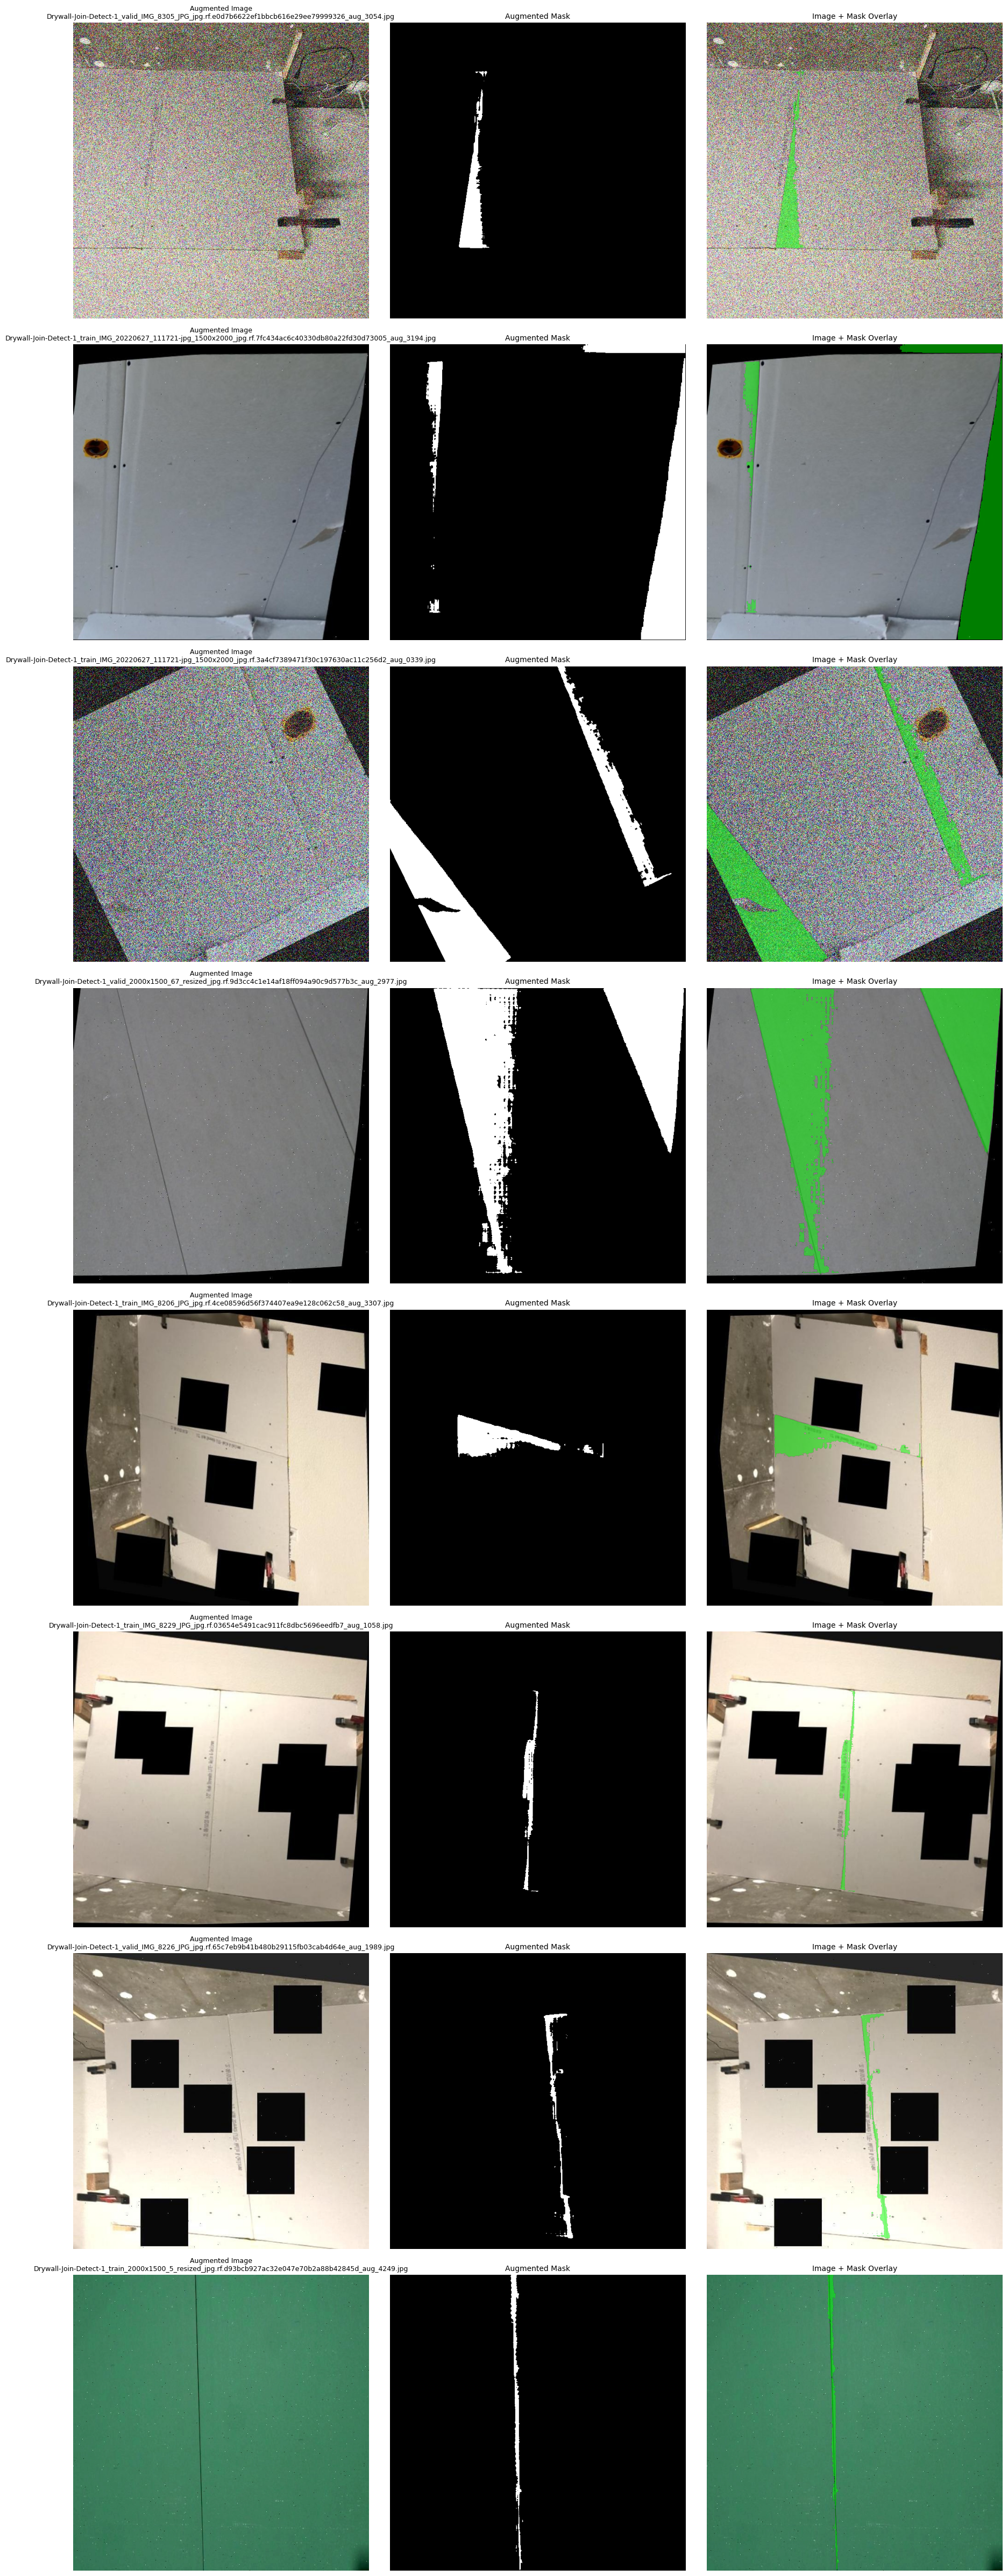


✓ Displayed 8 augmented samples


In [6]:
# Visualize some augmented samples
import matplotlib.pyplot as plt
import random

def visualize_augmentations(output_img_dir, output_mask_dir, num_samples=3):
    """
    Visualize augmented images with their masks
    """
    # Get list of augmented files
    aug_files = [f for f in os.listdir(output_img_dir) if 'aug_' in f]
    
    if len(aug_files) == 0:
        print("No augmented files found!")
        return
    
    # Select random samples
    samples = random.sample(aug_files, min(num_samples, len(aug_files)))
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(18, 6*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for idx, img_file in enumerate(samples):
        # Load augmented image
        img_path = os.path.join(output_img_dir, img_file)
        image_bgr = cv2.imread(img_path)
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        
        # Load corresponding mask
        mask_file = img_file.replace('.jpg', '.png')
        mask_path = os.path.join(output_mask_dir, mask_file)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask_bool = mask > 0
        
        # Plot 1: Augmented Image
        axes[idx, 0].imshow(image_rgb)
        axes[idx, 0].set_title(f'Augmented Image\n{img_file}', fontsize=9)
        axes[idx, 0].axis('off')
        
        # Plot 2: Mask
        axes[idx, 1].imshow(mask, cmap='gray')
        axes[idx, 1].set_title('Augmented Mask', fontsize=10)
        axes[idx, 1].axis('off')
        
        # Plot 3: Image with Mask Overlay
        axes[idx, 2].imshow(image_rgb)
        mask_overlay = np.zeros((*mask_bool.shape, 4))
        mask_overlay[mask_bool] = [0, 1, 0, 0.5]  # Green overlay
        axes[idx, 2].imshow(mask_overlay)
        axes[idx, 2].set_title('Image + Mask Overlay', fontsize=10)
        axes[idx, 2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Displayed {num_samples} augmented samples")

print("="*60)
print("VISUALIZING AUGMENTED SAMPLES")
print("="*60)
visualize_augmentations(OUTPUT_IMG_DIR, OUTPUT_MASK_DIR, num_samples=8)

In [7]:
# Get final dataset statistics
import os

def get_final_dataset_stats():
    """
    Calculate final dataset statistics including original and augmented data
    """
    print("="*70)
    print("FINAL DATASET STATISTICS")
    print("="*70)
    
    # Cracks dataset (original only)
    cracks_count = 0
    cracks_masks = 0
    
    for split in ['train', 'valid', 'test']:
        split_dir = os.path.join(CRACKS_PATH, split)
        if os.path.exists(split_dir):
            images = [f for f in os.listdir(split_dir) 
                     if f.endswith(('.jpg', '.jpeg', '.png')) and not f.startswith('_')]
            cracks_count += len(images)
    
    # Count cracks masks
    cracks_masks = len([f for f in os.listdir(MASKS_DIR) 
                       if f.startswith("cracks-1") and f.endswith('.png')])
    
    # Drywall dataset (original)
    drywall_original = 0
    drywall_original_masks = 0
    
    for split in ['train', 'valid', 'test']:
        split_dir = os.path.join(DRYWALL_PATH, split)
        if os.path.exists(split_dir):
            images = [f for f in os.listdir(split_dir) 
                     if f.endswith(('.jpg', '.jpeg', '.png')) and not f.startswith('_')]
            drywall_original += len(images)
    
    # Count original drywall masks
    drywall_original_masks = len([f for f in os.listdir(MASKS_DIR) 
                                 if f.startswith("Drywall-Join-Detect-1") and f.endswith('.png')])
    
    # Drywall augmented
    drywall_augmented = 0
    drywall_augmented_masks = 0
    
    if os.path.exists(OUTPUT_IMG_DIR):
        drywall_augmented = len([f for f in os.listdir(OUTPUT_IMG_DIR) 
                                if f.endswith(('.jpg', '.jpeg', '.png'))])
        drywall_augmented_masks = len([f for f in os.listdir(OUTPUT_MASK_DIR) 
                                      if f.endswith('.png')])
    
    # Total drywall (original + augmented)
    drywall_total = drywall_augmented  # augmented folder contains originals + augmented
    drywall_total_masks = drywall_augmented_masks
    
    # Print results
    print("\n📊 CRACKS Dataset:")
    print(f"   Images: {cracks_count:,}")
    print(f"   Masks:  {cracks_masks:,}")
    print(f"   Location: {CRACKS_PATH}")
    print(f"   Masks Location: {MASKS_DIR}")
    
    print("\n📊 DRYWALL Dataset:")
    print(f"   Original Images: {drywall_original:,}")
    print(f"   Original Masks:  {drywall_original_masks:,}")
    print(f"   Augmented Images: {drywall_augmented:,} (includes originals)")
    print(f"   Augmented Masks:  {drywall_augmented_masks:,} (includes originals)")
    print(f"   Original Location: {DRYWALL_PATH}")
    print(f"   Original Masks: {MASKS_DIR}")
    print(f"   Augmented Images: {OUTPUT_IMG_DIR}")
    print(f"   Augmented Masks: {OUTPUT_MASK_DIR}")
    
    print("\n📈 COMBINED STATISTICS:")
    total_images = cracks_count + drywall_augmented
    total_masks = cracks_masks + drywall_augmented_masks
    print(f"   Total Images: {total_images:,}")
    print(f"   Total Masks:  {total_masks:,}")
    
    print("\n⚖️  CLASS BALANCE:")
    if drywall_augmented > 0:
        ratio = cracks_count / drywall_augmented
        print(f"   Cracks : Drywall = {cracks_count:,} : {drywall_augmented:,}")
        print(f"   Ratio: {ratio:.2f}:1")
        if 0.9 <= ratio <= 1.1:
            print("   ✅ Classes are well balanced!")
        elif ratio < 0.9:
            print("   ⚠️  Drywall has more samples than Cracks")
        else:
            print("   ⚠️  Cracks has more samples than Drywall")
    else:
        print("   ⚠️  No augmented data found yet")
    
    print("\n" + "="*70)
    
    return {
        'cracks': {'images': cracks_count, 'masks': cracks_masks},
        'drywall_original': {'images': drywall_original, 'masks': drywall_original_masks},
        'drywall_augmented': {'images': drywall_augmented, 'masks': drywall_augmented_masks},
        'total': {'images': total_images, 'masks': total_masks}
    }

# Get and display final statistics
stats = get_final_dataset_stats()

FINAL DATASET STATISTICS

📊 CRACKS Dataset:
   Images: 5,369
   Masks:  5,369
   Location: /kaggle/input/prompt-based-segmentation/cracks-1
   Masks Location: /kaggle/input/prompt-based-segmentation/processed_masks

📊 DRYWALL Dataset:
   Original Images: 1,022
   Original Masks:  1,022
   Augmented Images: 5,369 (includes originals)
   Augmented Masks:  5,369 (includes originals)
   Original Location: /kaggle/input/prompt-based-segmentation/Drywall-Join-Detect-1
   Original Masks: /kaggle/input/prompt-based-segmentation/processed_masks
   Augmented Images: augmented_drywall_images
   Augmented Masks: augmented_drywall_masks

📈 COMBINED STATISTICS:
   Total Images: 10,738
   Total Masks:  10,738

⚖️  CLASS BALANCE:
   Cracks : Drywall = 5,369 : 5,369
   Ratio: 1.00:1
   ✅ Classes are well balanced!



In [8]:
import os
import pandas as pd
import shutil
from sklearn.model_selection import train_test_split
from tqdm import tqdm

def create_final_dataset_structure(cracks_path, drywall_path, masks_dir, 
                                   augmented_img_dir, augmented_mask_dir, 
                                   output_dir):
    """
    Organizes images and masks into a unified structure and creates metadata files
    for training, validation, and testing with prompt-based annotations.
    """
    
    # 1. Define the final, clean directory structure
    final_images_dir = os.path.join(output_dir, "images")
    final_masks_dir = os.path.join(output_dir, "masks")
    
    os.makedirs(final_images_dir, exist_ok=True)
    os.makedirs(final_masks_dir, exist_ok=True)
    
    # 2. Define the prompts for each class as per the project goal
    drywall_prompts = ["segment taping area", "segment joint/tape", "segment drywall seam"]
    cracks_prompts = ["segment crack", "segment wall crack"]
    
    all_metadata = []
    
    print("="*70)
    print("CREATING UNIFIED DATASET STRUCTURE")
    print("="*70)
    
    # 3. Process CRACKS dataset (original data from all splits)
    print("\n📦 Processing CRACKS dataset...")
    cracks_count = 0
    
    for split in ['train', 'valid', 'test']:
        split_dir = os.path.join(cracks_path, split)
        if not os.path.exists(split_dir):
            continue
            
        image_files = [f for f in os.listdir(split_dir) 
                      if f.endswith(('.jpg', '.jpeg', '.png')) and not f.startswith('_')]
        
        for img_name in tqdm(image_files, desc=f"  Cracks/{split}"):
            source_img_path = os.path.join(split_dir, img_name)
            
            # Construct mask filename: cracks-1_{split}_{basename}.png
            base_name = os.path.splitext(img_name)[0]
            mask_name = f"cracks-1_{split}_{base_name}.png"
            source_mask_path = os.path.join(masks_dir, mask_name)
            
            # Skip if mask doesn't exist
            if not os.path.exists(source_mask_path):
                print(f"  Warning: Mask not found for '{img_name}'. Skipping.")
                continue
            
            # Create unique filenames for final dataset
            unique_img_name = f"crack_{split}_{base_name}.jpg"
            unique_mask_name = f"crack_{split}_{base_name}.png"
            
            dest_img_path = os.path.join(final_images_dir, unique_img_name)
            dest_mask_path = os.path.join(final_masks_dir, unique_mask_name)
            
            # Copy files
            shutil.copy(source_img_path, dest_img_path)
            shutil.copy(source_mask_path, dest_mask_path)
            
            # Create metadata record
            record = {
                "image_path": os.path.join("images", unique_img_name),
                "mask_path": os.path.join("masks", unique_mask_name),
                "class_name": "crack",
                "prompts": str(cracks_prompts),
                "source_split": split
            }
            all_metadata.append(record)
            cracks_count += 1
    
    print(f"  ✓ Processed {cracks_count} crack images")
    
    # 4. Process DRYWALL dataset (augmented data - includes originals + augmented)
    print("\n📦 Processing DRYWALL dataset (augmented)...")
    drywall_count = 0
    
    if os.path.exists(augmented_img_dir) and os.path.exists(augmented_mask_dir):
        image_files = [f for f in os.listdir(augmented_img_dir) 
                      if f.endswith(('.jpg', '.jpeg', '.png'))]
        
        for img_name in tqdm(image_files, desc="  Drywall (augmented)"):
            source_img_path = os.path.join(augmented_img_dir, img_name)
            
            # Corresponding mask has .png extension
            mask_name = os.path.splitext(img_name)[0] + ".png"
            source_mask_path = os.path.join(augmented_mask_dir, mask_name)
            
            # Skip if mask doesn't exist
            if not os.path.exists(source_mask_path):
                print(f"  Warning: Mask not found for '{img_name}'. Skipping.")
                continue
            
            # Create unique filenames
            base_name = os.path.splitext(img_name)[0]
            unique_img_name = f"drywall_{base_name}.jpg"
            unique_mask_name = f"drywall_{base_name}.png"
            
            dest_img_path = os.path.join(final_images_dir, unique_img_name)
            dest_mask_path = os.path.join(final_masks_dir, unique_mask_name)
            
            # Copy files
            shutil.copy(source_img_path, dest_img_path)
            shutil.copy(source_mask_path, dest_mask_path)
            
            # Determine original split from filename
            if '_train_' in img_name:
                orig_split = 'train'
            elif '_valid_' in img_name:
                orig_split = 'valid'
            elif '_test_' in img_name:
                orig_split = 'test'
            else:
                orig_split = 'unknown'
            
            # Create metadata record
            record = {
                "image_path": os.path.join("images", unique_img_name),
                "mask_path": os.path.join("masks", unique_mask_name),
                "class_name": "drywall",
                "prompts": str(drywall_prompts),
                "source_split": orig_split
            }
            all_metadata.append(record)
            drywall_count += 1
    else:
        print("  ⚠️  Augmented drywall directories not found!")
        print(f"     Expected: {augmented_img_dir}")
        print(f"              {augmented_mask_dir}")
    
    print(f"  ✓ Processed {drywall_count} drywall images (includes augmented)")
    
    # 5. Create and save the master metadata file
    if not all_metadata:
        print("\n❌ No data was processed. Please check your input directories.")
        return
    
    master_df = pd.DataFrame(all_metadata)
    master_df.to_csv(os.path.join(output_dir, "metadata.csv"), index=False)
    print(f"\n✓ Master metadata.csv created with {len(master_df)} total entries.")
    
    # 6. Split the data into training, validation, and test sets (80/10/10 split)
    # Use stratification to ensure class balance is preserved in all splits
    print("\n📊 Splitting dataset into train/valid/test...")
    
    train_df, temp_df = train_test_split(
        master_df,
        test_size=0.2,
        random_state=42,
        stratify=master_df['class_name']
    )
    
    valid_df, test_df = train_test_split(
        temp_df,
        test_size=0.5,
        random_state=42,
        stratify=temp_df['class_name']
    )
    
    # Save the split CSV files
    train_df.to_csv(os.path.join(output_dir, "train.csv"), index=False)
    valid_df.to_csv(os.path.join(output_dir, "valid.csv"), index=False)
    test_df.to_csv(os.path.join(output_dir, "test.csv"), index=False)
    
    # 7. Print a summary of the final dataset
    print("\n" + "="*70)
    print("✅ DATASET RESTRUCTURING COMPLETE")
    print("="*70)
    print(f"Final dataset location: '{output_dir}'")
    print(f"\n📊 Total samples: {len(master_df):,}")
    print(f"   - Cracks:  {len(master_df[master_df['class_name'] == 'crack']):,}")
    print(f"   - Drywall: {len(master_df[master_df['class_name'] == 'drywall']):,}")
    print(f"\n📈 Data splits:")
    print(f"   - Training set:   {len(train_df):,} samples")
    print(f"     • Cracks:  {len(train_df[train_df['class_name'] == 'crack']):,}")
    print(f"     • Drywall: {len(train_df[train_df['class_name'] == 'drywall']):,}")
    print(f"   - Validation set: {len(valid_df):,} samples")
    print(f"     • Cracks:  {len(valid_df[valid_df['class_name'] == 'crack']):,}")
    print(f"     • Drywall: {len(valid_df[valid_df['class_name'] == 'drywall']):,}")
    print(f"   - Test set:       {len(test_df):,} samples")
    print(f"     • Cracks:  {len(test_df[test_df['class_name'] == 'crack']):,}")
    print(f"     • Drywall: {len(test_df[test_df['class_name'] == 'drywall']):,}")
    print(f"\n📁 Output files:")
    print(f"   - images/     ({len(os.listdir(final_images_dir))} files)")
    print(f"   - masks/      ({len(os.listdir(final_masks_dir))} files)")
    print(f"   - metadata.csv")
    print(f"   - train.csv")
    print(f"   - valid.csv")
    print(f"   - test.csv")
    print("="*70)
    
    return master_df, train_df, valid_df, test_df


# Run the dataset restructuring
FINAL_DATASET_DIR = "final_dataset"

master_df, train_df, valid_df, test_df = create_final_dataset_structure(
    cracks_path=CRACKS_PATH,
    drywall_path=DRYWALL_PATH,
    masks_dir=MASKS_DIR,
    augmented_img_dir=OUTPUT_IMG_DIR,
    augmented_mask_dir=OUTPUT_MASK_DIR,
    output_dir=FINAL_DATASET_DIR
)

CREATING UNIFIED DATASET STRUCTURE

📦 Processing CRACKS dataset...


  Cracks/test: 100%|██████████| 4/4 [00:00<00:00, 171.15it/s]


  ✓ Processed 5369 crack images

📦 Processing DRYWALL dataset (augmented)...


  Drywall (augmented): 100%|██████████| 5369/5369 [00:01<00:00, 3512.60it/s]


  ✓ Processed 5369 drywall images (includes augmented)

✓ Master metadata.csv created with 10738 total entries.

📊 Splitting dataset into train/valid/test...

✅ DATASET RESTRUCTURING COMPLETE
Final dataset location: 'final_dataset'

📊 Total samples: 10,738
   - Cracks:  5,369
   - Drywall: 5,369

📈 Data splits:
   - Training set:   8,590 samples
     • Cracks:  4,295
     • Drywall: 4,295
   - Validation set: 1,074 samples
     • Cracks:  537
     • Drywall: 537
   - Test set:       1,074 samples
     • Cracks:  537
     • Drywall: 537

📁 Output files:
   - images/     (10738 files)
   - masks/      (10738 files)
   - metadata.csv
   - train.csv
   - valid.csv
   - test.csv
